<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

Задача: спрогнозировать стоимость автомобилей, используя данные 



Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. Для этого, перед обработкой данных, предварительно проведем парсинг данных с сайта auto.ru.

# 0. Import

In [1]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
from datetime import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 76

## 0.1. Функции, используемые в проекте

In [5]:
# Средняя абсолютная ошибка в %
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 1. Парсинг данных с сайта auto.ru

Весь парсинг зацитирован в силу того, что выполнен заранее на локальной машине и результат выгружен в проект. Сам парсинг выполняется очень долго.

In [6]:
# Начальный URL для дальнейшего парсинга
URL = 'https://auto.ru/moskva/cars/used/'
# Пустой список со ссылками на автомобили
pages_url_list = []

In [1]:
# Набирает список из ссылок на авто
"""while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( URL+'?page=%s'%i)#необходимо для смены страницы
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
           #Проверяем условие присутствия в списке проверяемой ссылки
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    #ждем 1 секунду до следующего запроса
    time.sleep(1)"""

'while len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( URL+\'?page=%s\'%i)#необходимо для смены страницы\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n           #Проверяем условие присутствия в списке проверяемой ссылки\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    #ждем 1 секунду до следующего запроса\n    time.sleep(1)'

Теперь, когда мы собрали список из ссылок на авто, можно спарсить все данные по этим ссылкам:

In [8]:
# создаем пустой список с данными по авто
"""cars_list = []
#используем наш список со ссылками
for item in pages_url_list:
   response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
   #загружаем страницу
    if page.find('div', class_='CardSold') == None:
       try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        #Заполняем словарь с данными по каждому автомобилю и добавляем в список с авто
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

#Таймер
    print('Ожидаю 0.5 секунды...')
    time.sleep(0.5)"""

'cars_list = []\n#используем наш список со ссылками\nfor item in pages_url_list:\n   response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n   #загружаем страницу\n    if page.find(\'div\', class_=\'CardSold\') == None:\n       try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        #Заполняем словарь с данными по каждому автомобилю и добавляем в список с авто\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine

Теперь приведем полученные данные к удобному формату

In [9]:
"""df = pd.DataFrame(cars_list)
#Сохраним в csv формате
df.to_csv('cars_autoru.csv', index=False)"""

"df = pd.DataFrame(cars_list)\n#Сохраним в csv формате\ndf.to_csv('cars_autoru.csv', index=False)"

# 2. Setup

Загружаем исходные данные для обучения, предложенные условиями задания:

In [10]:
VERSION = 16
DIR_TRAIN = '../input/parsing1/'  # Дата-Сет из парсинга
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

# 3. Data

In [11]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  parsing1  sf-dst-car-price-prediction


Теперь загрузим фреймы:

In [12]:
train = pd.read_csv(DIR_TRAIN+'cars_auto_ru.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Проверим, все ли получилось:

In [13]:
train.head(5)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/qashqai/...,чёрный,Только СЕГОДНЯ И ЗАВТРА при покупке этого авто...,2.0 LTR,144 N12,бензин,https://autoru.naydex.net/MgMy88H00/2e4ded1vP7...,69 850 км,...,2016,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1 319 000 ₽
1,купе,MERCEDES,https://auto.ru/cars/used/sale/mercedes/c_klas...,чёрный,"Авто в идеальном состоянии,ухожена,без дтп(мел...",1.6 LTR,156 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,119 075 км,...,2014,COUPE AUTOMATIC 1.6,автоматическая,2 владельца,Дубликат,задний,Левый,Не требует ремонта,Растаможен,1 470 000 ₽
2,внедорожник 5 дв.,LAND_ROVER,https://auto.ru/cars/used/sale/land_rover/rang...,серый,Пробег 25 800! \nОтличная комплектация.\n2 вла...,2.0 LTR,300 N12,бензин,https://autoru.naydex.net/MgMy88H00/2e4ded1vP7...,25 800 км,...,2018,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4 447 000 ₽
3,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11046295...,коричневый,"Продам BMW X1 18d.\nКупил в марте 2017 года, с...",2.0 LTR,150 N12,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,56 000 км,...,2016,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2 069 990 ₽
4,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11041506...,коричневый,Репутация для нас превыше всего!\nТолько прове...,3.0 LTR,218 N12,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,80 800 км,...,2015,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2 760 000 ₽


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37603 entries, 0 to 37602
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              37603 non-null  object
 1   brand                 37603 non-null  object
 2   car_url               37603 non-null  object
 3   color                 37603 non-null  object
 4   description           37603 non-null  object
 5   engineDisplacement    37603 non-null  object
 6   enginePower           37603 non-null  object
 7   fuelType              37603 non-null  object
 8   image                 37603 non-null  object
 9   mileage               37603 non-null  object
 10  modelDate             37603 non-null  int64 
 11  model_name            37603 non-null  object
 12  name                  37603 non-null  object
 13  numberOfDoors         37603 non-null  int64 
 14  priceCurrency         37603 non-null  object
 15  productionDate        37603 non-null

In [15]:
train.isna().sum()

bodyType                0
brand                   0
car_url                 0
color                   0
description             0
engineDisplacement      0
enginePower             0
fuelType                0
image                   0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
priceCurrency           0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

**Важное замечание:** Парсинг выполнялся на локальной машине, выполнялся очень долго.

Проверим тестовый фрейм:

In [16]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

проверим пропуски в тестовом фрейме:

In [18]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## 3.1. Data Preprocessing

К сожалению спарсить получилось далеко не все данные, которые находятся в тестовом дата-фрейме. Удалим некоторые из признаков, которые на наш взгляд не несут нагрузки:

In [19]:
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

Теперь посмотрим, что вышло:

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   description           34686 non-null  object
 5   engineDisplacement    34686 non-null  object
 6   enginePower           34686 non-null  object
 7   fuelType              34686 non-null  object
 8   image                 34686 non-null  object
 9   mileage               34686 non-null  int64 
 10  modelDate             34686 non-null  int64 
 11  model_name            34686 non-null  object
 12  name                  34686 non-null  object
 13  numberOfDoors         34686 non-null  int64 
 14  parsing_unixtime      34686 non-null  int64 
 15  priceCurrency         34686 non-null

Теперь посмотрим, есть ли дубликаты в тренировочном дата-сете:

In [21]:
train['car_url'].duplicated().sum()

366

Удалим их:

In [22]:
# Удалим, указав столбец, по которому смотреть дубликаты
train = train.drop_duplicates(subset=['car_url'])

Проверим, везде ли в тренировочном фрейме есть цена:

In [23]:
train.price.isna().sum()

0

Цена присутствует у всех строк во фрейме.

Как мы видим, в некоторых столбцах присутствуют пропуски, с которыми мы в дальнейшем проведем работу и решим, как их заполнить. В целом мы имеем примерно одинаковые по размеру тестовый и тренировочный дата-сеты, примерно по 34 тысячи строк. Теперь, когда первичная обработка данных закончена, можно перейти к более сложным и интересным моментам.

## 3.2. Подготовка и Feature Engeneering

Теперь стоит сформировать списки, в которых будут храниться интересные нам признаки. Их, как обычно, будет три: бинарные, числовые и категориальные:

In [24]:
# Бинарные признаки - ноль или единица
bin_cols = []

# Категориальные признаки
cat_cols = []

# числовые признаки
num_cols = []

Теперь пойдем слева-напаво по нашим столбцам и рассмотрим, что мы можем выделить из них для дальнейшего обучения модели.

### 3.2.1. Столбец bodyType

Данный столбец отражает тип кузова автомобиля. Посмотрим на количество вариантов:

In [25]:
train.bodyType.unique()

array(['внедорожник 5 дв.', 'купе', 'седан', 'хэтчбек 5 дв.',
       'внедорожник 3 дв.', 'лифтбек', 'минивэн', 'компактвэн',
       'универсал 5 дв.', 'хэтчбек 3 дв.', 'пикап одинарная кабина',
       'пикап двойная кабина', 'купе-хардтоп', 'кабриолет', 'фургон',
       'родстер', 'лимузин', 'микровэн', 'тарга', 'хэтчбек 4 дв.',
       'пикап полуторная кабина', 'фастбек', 'седан-хардтоп',
       'внедорожник открытый', 'седан 2 дв.', 'универсал 3 дв.'],
      dtype=object)

Видно, что многие названия на самом деле одинаковые, различие только в указании дверей. Попробуем преобразовать названия:

In [26]:
# Выбираем первое слово для описания типа кузова
train['bodyType'] = train['bodyType'].astype(
    str).apply(lambda x: None if x.strip() == '' else x)
# Понижаем регистр первого слова
train['bodyType'] = train.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [27]:
train.bodyType.unique()

array(['внедорожник', 'купе', 'седан', 'хэтчбек', 'лифтбек', 'минивэн',
       'компактвэн', 'универсал', 'пикап', 'купе-хардтоп', 'кабриолет',
       'фургон', 'родстер', 'лимузин', 'микровэн', 'тарга', 'фастбек',
       'седан-хардтоп'], dtype=object)

Вариантов стало меньше, посмотрим на их общее количество:

In [28]:
train.bodyType.value_counts()

внедорожник      14771
седан            12858
хэтчбек           3088
лифтбек           2207
универсал         1336
минивэн            918
купе               819
компактвэн         518
пикап              252
купе-хардтоп       154
фургон             129
родстер             90
кабриолет           63
седан-хардтоп       17
микровэн            11
лимузин              3
тарга                2
фастбек              1
Name: bodyType, dtype: int64

Теперь проделаем то же самое для тестового фрейма.

In [29]:
# Смотрим уникальные значения
test.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [30]:
# Выбираем первое слово для описания типа кузова
test['bodyType'] = test['bodyType'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
# Понижаем регистр первого слова
test['bodyType'] = test.bodyType.apply(lambda x: x.split(' ')[0].lower())

Посмотрим на результаты:

In [31]:
test.bodyType.unique()

array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон'], dtype=object)

In [32]:
test.bodyType.value_counts()

седан            13153
внедорожник      12346
хэтчбек           2609
лифтбек           2232
универсал         1276
минивэн            995
купе               824
компактвэн         489
пикап              290
купе-хардтоп       158
родстер             99
фургон              97
кабриолет           90
седан-хардтоп       12
микровэн             7
лимузин              6
тарга                2
фастбек              1
Name: bodyType, dtype: int64

Данный признак можно отнести к категориальным, что мы и сделаем:

In [33]:
cat_cols.append('bodyType')

### 3.2.2. Столбец Brand

Данный столбец отражает название фирмы-производителя автомобиля,посмотрим, нет ли там пропусков:

In [34]:
train.brand.isna().sum()

0

Пропусков нет, следовательно столбец можно обрабатывать дальше. Посмотрим на уникальные значения:

In [35]:
train.brand.unique()

array(['NISSAN', 'MERCEDES', 'LAND_ROVER', 'BMW', 'VOLKSWAGEN', 'LEXUS',
       'VOLVO', 'HYUNDAI', 'HAVAL', 'PORSCHE', 'AUDI', 'SUZUKI',
       'RENAULT', 'JAGUAR', 'DODGE', 'SKODA', 'CHANGAN', 'KIA', 'CITROEN',
       'TOYOTA', 'VAZ', 'MITSUBISHI', 'MAZDA', 'CHEVROLET', 'FORD', 'UAZ',
       'VORTEX', 'MINI', 'HONDA', 'OPEL', 'SUBARU', 'JEEP', 'PEUGEOT',
       'GAZ', 'GREAT_WALL', 'SSANG_YONG', 'CADILLAC', 'MASERATI',
       'INFINITI', 'CHERY', 'GEELY', 'FIAT', 'BAIC', 'RAM', 'DATSUN',
       'PONTIAC', 'CHRYSLER', 'ROLLS_ROYCE', 'ZAZ', 'TESLA', 'DAEWOO',
       'BENTLEY', 'GMC', 'LIFAN', 'SEAT', 'FAW', 'GAC', 'SMART',
       'FERRARI', 'GENESIS', 'TAGAZ', 'IG', 'ACURA', 'IRAN_KHODRO',
       'LINCOLN', 'MCLAREN', 'BRILLIANCE', 'ALFA_ROMEO', 'LANCIA',
       'HUMMER', 'RAVON', 'DAIHATSU', 'HAFEI', 'SAAB', 'LAMBORGHINI',
       'LUXGEN', 'ZOTYE', 'DW_HOWER', 'MOSCVICH', 'MG', 'TATRA', 'SATURN'],
      dtype=object)

Посмотрим на количество брендов того или иного авто:

In [36]:
train.brand.value_counts()

MERCEDES      4338
VOLKSWAGEN    4166
BMW           4158
TOYOTA        4023
NISSAN        3952
              ... 
MCLAREN          1
HAFEI            1
SATURN           1
DW_HOWER         1
RAVON            1
Name: brand, Length: 82, dtype: int64

На основе предоставленных данных, можно сказать, что на сайте также представлены единичные объявления. Попробуем уменьшить количество брендов, оставив только те, вклад которых составляет не менее 2% дата-сета. Остальные запишем в Other.

In [37]:
all_brands = len(train.brand)
brands_train = train.brand.value_counts()

Теперь вычислим процентное соотношение каждого бренда во всем списке:

In [38]:
brand_to_all_train = brands_train/all_brands*100

Посмотрим результат:

In [39]:
brand_to_all_train

MERCEDES      11.649703
VOLKSWAGEN    11.187797
BMW           11.166313
TOYOTA        10.803770
NISSAN        10.613100
                ...    
MCLAREN        0.002686
HAFEI          0.002686
SATURN         0.002686
DW_HOWER       0.002686
RAVON          0.002686
Name: brand, Length: 82, dtype: float64

Запишем все, что меньше 2% в Other:

In [40]:
train['brand_new'] = train.brand.apply(
    lambda x: x if brand_to_all_train[x] > 2 else 'other')

Результат:

In [41]:
train.brand_new.value_counts()

MERCEDES      4338
VOLKSWAGEN    4166
BMW           4158
TOYOTA        4023
NISSAN        3952
other         3710
AUDI          2994
SKODA         2592
MITSUBISHI    2395
VOLVO         1263
LEXUS         1102
HONDA         1033
INFINITI       763
KIA            748
Name: brand_new, dtype: int64

Так-как наша задача предсказать правильно цену для тестовой выборки, посмотрим, попали ли какие-либо модели из выборки в категорию "other"

In [42]:
test['brand_new'] = train.brand.apply(
    lambda x: x if brand_to_all_train[x] > 2 else 'other')

In [43]:
test.brand_new.value_counts()

MERCEDES      4338
VOLKSWAGEN    4166
BMW           4158
TOYOTA        4023
NISSAN        3952
other         3710
SKODA         2592
MITSUBISHI    2395
AUDI          2044
LEXUS         1102
INFINITI       763
KIA            748
VOLVO          207
HONDA          127
Name: brand_new, dtype: int64

Как мы можем увидеть, все модели остались в изначальном списке. Данный столбец можно отнести к категориальным, но предварительно посмотрим графически, каких брендов больше:

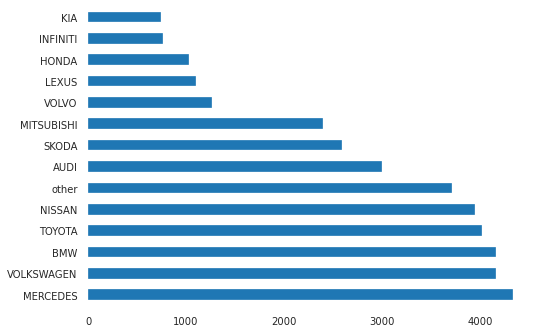

In [44]:
train.brand_new.value_counts().plot.barh()

Видно, что бренды, которые мы отнесли к Other теперь находятся на 6 месте по количеству упоминаний. Но без таких манипуляций возникло бы слишком много уникальных значений. Запишем признак в cat_cols:

In [45]:
cat_cols.append('brand_new')

### 3.2.3. Столбец car_url

Данный признак хранит ссылку на объявление о продаже автомобиля. Для обучения использовать не будем, так как смысловой нагрузки он не несет.

### 3.2.4. Столбец color

Данный признак отражает цвет продаваемого автомобиля. Посмотрим количество уникальных значений:

In [46]:
train.color.nunique()

16

Сделаем то же самое для тестовой выборки:

In [47]:
test.color.nunique()

16

Проверим на пропуски и добавим к категориальным признакам:

In [48]:
print(train.color.isna().sum())
print(test.color.isna().sum())

0
0


Пропусков нет, добавляем к категориальным признакам.

In [49]:
cat_cols.append('color')

### 3.2.5. Столбец description

Данный признак содержит описание продовца о продоваемом автомобиле. Проверим есть ли пропуски:

In [50]:
print(train.description.isna().sum())
print(test.description.isna().sum())

0
0


Пропусков нет, создадим признак, который бы отражал количество символов в описании:

In [51]:
train['comment_length'] = train.description.apply(lambda x: len(str(x)))

повторим для тестового фрейма:

In [52]:
test['comment_length'] = test.description.apply(lambda x: len(str(x)))

Теперь добавим к числовым признакам:

In [53]:
num_cols.append('comment_length')

### 3.2.6. Столбец EngineDisplacement

Этот признак описывает объем двигателя авто. Посмотрим количество уникальных значений :

In [54]:
train.engineDisplacement.unique()

array(['2.0 LTR', '1.6 LTR', '3.0 LTR', '1.8 LTR', '2.5 LTR', '1.5 LTR',
       '1.3 LTR', '3.5 LTR', '2.4 LTR', '5.5 LTR', '2.1 LTR', '4.5 LTR',
       '2.2 LTR', '4.4 LTR', '1.4 LTR', '2.7 LTR', '4.7 LTR', '2.3 LTR',
       '4.8 LTR', '2.9 LTR', '1.1 LTR', '5.2 LTR', '4.0 LTR', '1.2 LTR',
       '2.8 LTR', '3.7 LTR', '1.7 LTR', '5.3 LTR', '1.0 LTR', '3.8 LTR',
       '5.6 LTR', '3.6 LTR', '3.2 LTR', '5.7 LTR', '4.1 LTR', '4.6 LTR',
       '1.9 LTR', ' LTR', '6.4 LTR', '6.2 LTR', '3.1 LTR', '5.0 LTR',
       '6.0 LTR', '4.2 LTR', '6.6 LTR', '0.8 LTR', '3.4 LTR', '2.6 LTR',
       '3.3 LTR', '5.4 LTR', '5.8 LTR', '6.8 LTR', '0.9 LTR', '4.3 LTR',
       '0.7 LTR', '6.5 LTR', '4.9 LTR', '0.6 LTR', '3.9 LTR', '6.3 LTR',
       '5.9 LTR'], dtype=object)

Повторим для тестовой выборки:

In [55]:
test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

Мы видим, что признак отражает литраж двигателя с припиской LTR. Попробуем ее убрать:

In [56]:
train.engineDisplacement = train.engineDisplacement.apply(lambda x: x[:3])

In [57]:
train.engineDisplacement.unique()

array(['2.0', '1.6', '3.0', '1.8', '2.5', '1.5', '1.3', '3.5', '2.4',
       '5.5', '2.1', '4.5', '2.2', '4.4', '1.4', '2.7', '4.7', '2.3',
       '4.8', '2.9', '1.1', '5.2', '4.0', '1.2', '2.8', '3.7', '1.7',
       '5.3', '1.0', '3.8', '5.6', '3.6', '3.2', '5.7', '4.1', '4.6',
       '1.9', ' LT', '6.4', '6.2', '3.1', '5.0', '6.0', '4.2', '6.6',
       '0.8', '3.4', '2.6', '3.3', '5.4', '5.8', '6.8', '0.9', '4.3',
       '0.7', '6.5', '4.9', '0.6', '3.9', '6.3', '5.9'], dtype=object)

Видно, что есть значения LT, которые остались неизменными после преобразования. Заменим наиболее частым значением:

In [58]:
train.engineDisplacement = train.engineDisplacement.replace(
    ' LT', train.engineDisplacement.mode()[0])

Проверим:

In [59]:
train.engineDisplacement.unique()

array(['2.0', '1.6', '3.0', '1.8', '2.5', '1.5', '1.3', '3.5', '2.4',
       '5.5', '2.1', '4.5', '2.2', '4.4', '1.4', '2.7', '4.7', '2.3',
       '4.8', '2.9', '1.1', '5.2', '4.0', '1.2', '2.8', '3.7', '1.7',
       '5.3', '1.0', '3.8', '5.6', '3.6', '3.2', '5.7', '4.1', '4.6',
       '1.9', '6.4', '6.2', '3.1', '5.0', '6.0', '4.2', '6.6', '0.8',
       '3.4', '2.6', '3.3', '5.4', '5.8', '6.8', '0.9', '4.3', '0.7',
       '6.5', '4.9', '0.6', '3.9', '6.3', '5.9'], dtype=object)

Теперь все впорядке. Проверим для тестовой выборки:

In [60]:
test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

Проведем те же преобразования:

In [61]:
test.engineDisplacement = test.engineDisplacement.apply(lambda x: x[:3])

In [62]:
# Теперь уберем LT
test.engineDisplacement = test.engineDisplacement.replace(
    ' LT', test.engineDisplacement.mode()[0])

In [63]:
test.engineDisplacement.unique()

array(['1.2', '1.6', '1.8', '2.0', '1.4', '1.3', '1.0', '3.6', '1.5',
       '1.9', '2.8', '1.1', '2.5', '4.2', '3.0', '4.0', '5.9', '2.7',
       '3.1', '2.4', '5.2', '3.2', '4.1', '6.3', '2.3', '6.0', '2.2',
       '3.7', '2.9', '5.0', '3.3', '2.1', '2.6', '3.5', '1.7', '0.7',
       '4.4', '4.8', '5.4', '6.6', '4.9', '3.8', '3.4', '3.9', '4.6',
       '5.6', '4.5', '5.5', '6.2', '4.7', '4.3', '5.8', '5.3', '5.7'],
      dtype=object)

преобразуем признак из обоих фреймов в числовой:

In [64]:
train.engineDisplacement = train.engineDisplacement.apply(lambda x: float(x))
# Тестовый
test.engineDisplacement = test.engineDisplacement.apply(lambda x: float(x))

Посмотрим на распределение признака:

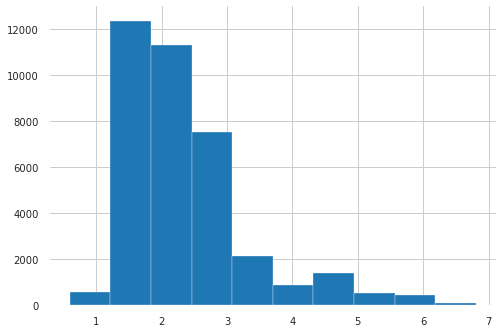

In [65]:
train.engineDisplacement.hist()

Для тестовой выборки:

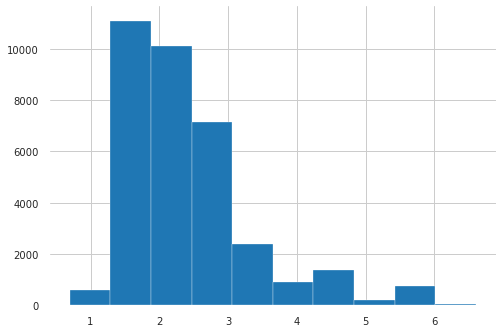

In [66]:
test.engineDisplacement.hist()

Как мы видим, распределения похожи, основную часть предложений составляют авто с объемом двигателя от 1.3 до 2.5 литра. Никаких выбросов не наблюдается.

Теперь добавим признак к числовым столбцам:

In [67]:
num_cols.append('engineDisplacement')

### 3.2.7. Столбец enginePower

Признак отражает мощность двигателя автомобиля. Посмотрим на уникальные значения:

In [68]:
train.enginePower.unique()

array(['144 N12', '156 N12', '300 N12', '150 N12', '218 N12', '180 N12',
       '208 N12', '123 N12', '90 N12', '360 N12', '252 N12', '340 N12',
       '106 N12', '110 N12', '152 N12', '525 N12', '170 N12', '200 N12',
       '249 N12', '113 N12', '188 N12', '114 N12', '115 N12', '245 N12',
       '122 N12', '275 N12', '109 N12', '82 N12', '167 N12', '87 N12',
       '204 N12', '102 N12', '235 N12', '240 N12', '197 N12', '339 N12',
       '194 N12', '130 N12', '190 N12', '128 N12', '388 N12', '140 N12',
       '210 N12', '125 N12', '75 N12', '220 N12', '435 N12', '105 N12',
       '145 N12', '161 N12', '98 N12', '355 N12', '80 N12', '143 N12',
       '330 N12', '120 N12', '184 N12', '333 N12', '211 N12', '163 N12',
       '135 N12', '107 N12', '65 N12', '149 N12', '112 N12', '215 N12',
       '550 N12', '126 N12', '181 N12', '224 N12', '100 N12', '88 N12',
       '177 N12', '201 N12', '97 N12', '116 N12', '160 N12', '231 N12',
       '185 N12', '277 N12', '81 N12', '175 N12', '178 N12',

Попробуем избавиться от дополнительной информации в обозначении:

In [69]:
train['enginePower'] = train['enginePower'].apply(
    lambda x: x[:1] if len(x) == 5 else (x[:2] if len(x) == 6 else x[:3]))

Проверим результат:

In [70]:
train.enginePower.unique()

array(['144', '156', '300', '150', '218', '180', '208', '123', '90',
       '360', '252', '340', '106', '110', '152', '525', '170', '200',
       '249', '113', '188', '114', '115', '245', '122', '275', '109',
       '82', '167', '87', '204', '102', '235', '240', '197', '339', '194',
       '130', '190', '128', '388', '140', '210', '125', '75', '220',
       '435', '105', '145', '161', '98', '355', '80', '143', '330', '120',
       '184', '333', '211', '163', '135', '107', '65', '149', '112',
       '215', '550', '126', '181', '224', '100', '88', '177', '201', '97',
       '116', '160', '231', '185', '277', '81', '175', '178', '146',
       '171', '141', '173', '117', '192', '272', '164', '84', '147',
       '174', '148', '129', '70', '95', '306', '124', '169', '625', '266',
       '324', '186', '500', '455', '314', '260', '335', '407', '86', '69',
       '193', '315', '83', '250', '430', '462', '405', '294', '136',
       '238', '400', '280', '320', '223', '290', '134', '367', '292',
 

Проделаем то же самое для тестового фрейма:

In [71]:
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

Теперь уберем ненужную информацию:

In [72]:
test['enginePower'] = test['enginePower'].apply(
    lambda x: x[:1] if len(x) == 5 else (x[:2] if len(x) == 6 else x[:3]))

Результат:

In [73]:
test.enginePower.unique()

array(['105', '110', '152', '200', '102', '150', '90', '180', '220',
       '122', '70', '140', '125', '54', '86', '75', '64', '95', '260',
       '170', '80', '68', '160', '115', '280', '53', '60', '143', '42',
       '101', '58', '193', '79', '30', '100', '50', '163', '225', '420',
       '211', '245', '560', '500', '249', '450', '605', '250', '354',
       '120', '290', '230', '350', '204', '255', '340', '177', '272',
       '372', '210', '130', '300', '190', '239', '435', '333', '271',
       '326', '238', '310', '233', '252', '133', '460', '520', '400',
       '525', '367', '265', '550', '580', '88', '165', '430', '335',
       '174', '224', '136', '256', '338', '112', '218', '360', '93',
       '182', '113', '240', '270', '137', '155', '61', '254', '116', '71',
       '285', '408', '166', '156', '257', '201', '162', '194', '142',
       '154', '147', '281', '243', '118', '128', '91', '83', '205', '247',
       '188', '295', '275', '78', '109', '94', '185', '258', '145', '132',
  

Теперь преобразуем в числовой формат:

In [74]:
train['enginePower'] = train['enginePower'].apply(lambda x: int(x))
test['enginePower'] = test['enginePower'].apply(lambda x: int(x))

Посмотрим распределение признака:

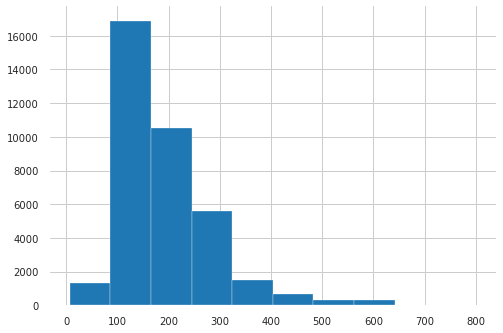

In [75]:
# Тренировочная выборка
train.enginePower.hist()

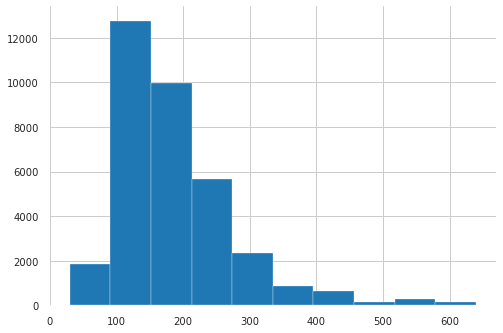

In [76]:
# Тестовая выборка
test.enginePower.hist()

Видно что большую часть представляют двигатели с мощностью от 100 до 250 л.с. Графики немного сдвинуты влево, явных выбросов не наблюдается.

Добавим признак в числовые:

In [77]:
num_cols.append('enginePower')

### 3.2.8. Столбец fuelType

Данный признак содержит данные о типе топлива, используемого в автомобиле. Посмотрим на уникальные значения:

In [78]:
print(train.fuelType.unique())
print(test.fuelType.unique())

['бензин' 'дизель' 'гибрид' 'электро' 'газ']
['бензин' 'дизель' 'гибрид' 'электро' 'газ']


Теперь посмотрим, есть ли в данных пропуски:

In [79]:
print(train.fuelType.isna().sum())
print(test.fuelType.isna().sum())

0
0


Пропусков нет,что очень радует. Теперь посмотрим распределение признака для обеих выборок:

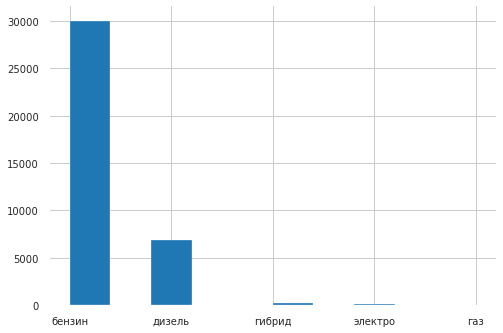

In [80]:
# Тренировочная выборка
train.fuelType.hist()

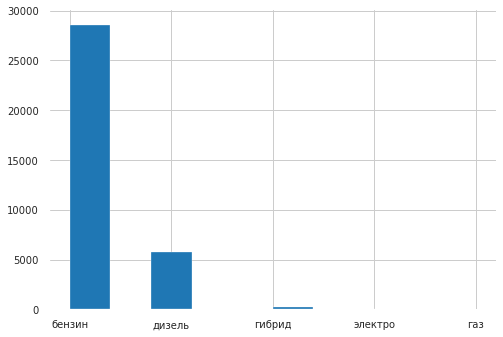

In [81]:
# Тестовая выборка
test.fuelType.hist()

Графики выборок схожи, основное количество представленных автомобилей работает на бензиновом топливе. Так как предварительной обработки признаку не требуется, добавим его в категориальные:

In [82]:
cat_cols.append('fuelType')

### 3.2.9. Столбец image

Данный признак содержит фото автомобиля. На мой взгляд особой информативности не несет, поэтому для обучения его брать не будем.

### 3.2.10. Столбец mileage

Признак содержит данные о пробеге продаваемого авто. Проверим есть ли пропуски:

In [83]:
print(train.mileage.isna().sum())
print(test.mileage.isna().sum())

0
0


Пропусков нет, проверим сами данные:

In [84]:
train.mileage.unique()

array(['69\xa0850\xa0км', '119\xa0075\xa0км', '25\xa0800\xa0км', ...,
       255999, 315164, 373317], dtype=object)

Видно, что данные грязные. Уберем из данных лишний мусор:

In [85]:
# убираем \xa0 из данных
train['mileage'] = train['mileage'].apply(lambda x: str(x).replace('\xa0', ''))
# убираем км из данных
train['mileage'] = train['mileage'].apply(lambda x: str(x).replace('км', ''))

Проверим результат:

In [86]:
train.mileage.unique()

array(['69850', '119075', '25800', ..., '255999', '315164', '373317'],
      dtype=object)

Замечательно! Мы убрали весь мусор, который мешал работать с данными. Проделаем то же самое для тестовой выборки:

In [87]:
# убираем \xa0 из данных
test['mileage'] = test['mileage'].apply(lambda x: str(x).replace('\xa0', ''))
# убираем км из данных
test['mileage'] = test['mileage'].apply(lambda x: str(x).replace('км', ''))

Теперь преобразуем в числовой формат:

In [88]:
# Тестовая выборка
test['mileage'] = test['mileage'].apply(lambda x: int(x))
# Обучающая выборка
train['mileage'] = train['mileage'].apply(lambda x: int(x))

Посмотрим распределение значений признака для обеих выборок:

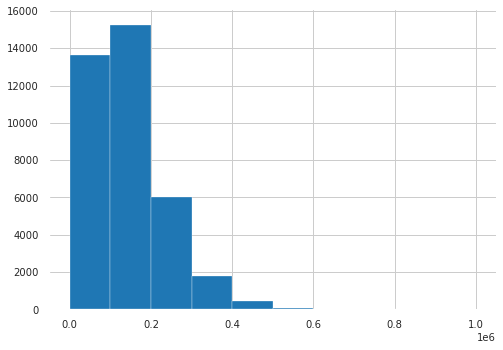

In [89]:
# Тренировочная выборка
train.mileage.hist()

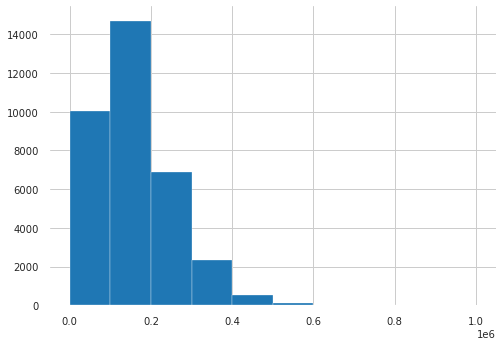

In [90]:
# Тестовая выборка
test.mileage.hist()

Теперь посмотрим на основные показатели признака:

In [91]:
train.mileage.describe()

count      37237.000000
mean      143512.051025
std        95159.767630
min            1.000000
25%        74792.000000
50%       130000.000000
75%       193318.000000
max      1000000.000000
Name: mileage, dtype: float64

In [92]:
test.mileage.describe()

count      34686.000000
mean      162009.767889
std       100676.559489
min            1.000000
25%        91153.500000
50%       149779.500000
75%       215000.000000
max      1000000.000000
Name: mileage, dtype: float64

Распределение на графике может считаться  нормальным, максимальное значение равно 1 млн. км. Является ли это выбросом? Вполне возможно, но есть автомобили, у которых пробег может быть еще больше. Такой вывод делаю, основываясь на собственном опыте. Для достоверности - можно посмотреть, какое количество значений привышается исходя из программного метода:

In [93]:
IQR = train['mileage'].quantile(0.75) - train['mileage'].quantile(0.25)
perc25 = train['mileage'].quantile(0.25)  # 25-й перцентиль
perc75 = train['mileage'].quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

25-й перцентиль: 74792.0, 75-й перцентиль: 193318.0, IQR: 118526.0,  Границы выбросов: [-102997.0, 371107.0].


Как мы видим, исходя из программного метода верхней границей является 371107 км. Но здравый смысл подсказывает, что могут быть значения и выше, и они вполне реальны. Посмотрим сколько значений привышает границу:

In [94]:
train.mileage[train.mileage > 371107].count()

913

Как мы видим значений очень мало, что логично. Оставим их без изменений. Посмотрим аналогично для тестовой выборки:

In [95]:
IQR = test['mileage'].quantile(0.75) - test['mileage'].quantile(0.25)
perc25 = test['mileage'].quantile(0.25)  # 25-й перцентиль
perc75 = test['mileage'].quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

25-й перцентиль: 91153.5, 75-й перцентиль: 215000.0, IQR: 123846.5,  Границы выбросов: [-94616.25, 400769.75].


Для теста верхний порог оказался даже выше, 400769 км. Посмотрим сколько значений его привышают:

In [96]:
test.mileage[test.mileage > 400769].count()

692

Значений также мало, оставим их без изменений. Добавим признак к числовым:

In [97]:
num_cols.append('mileage')

### 3.2.11. Столбец modelDate

Данный признак содержит информацию о годе производства модели авто. Посмотрим пропуски:

In [98]:
print(train.modelDate.isna().sum())
print(test.modelDate.isna().sum())

0
0


Перейдем к просмотру данных:

In [99]:
train.modelDate.unique()

array([2013, 2011, 2017, 2015, 2014, 2005, 2010, 2019, 2018, 2020, 2016,
       2000, 2008, 2012, 2009, 2004, 1972, 2006, 1998, 2007, 2002, 1995,
       2001, 1992, 2003, 1956, 1996, 1991, 1994, 1999, 1993, 1990, 1988,
       1997, 1982, 1987, 2021, 1976, 1984, 1983, 1973, 1986, 1979, 1989,
       1981, 1985, 1946, 1971, 1970, 1953, 1977, 1968, 1978, 1958, 1963,
       1955, 1964, 1974, 1965, 1980, 1959, 1969, 1975, 1961, 1952, 1960,
       1957, 1949, 1937, 1950, 1938])

In [100]:
test.modelDate.unique()

array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
       1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
       2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
       1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
       1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
       1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960])

Посмотрим график распределения признака:

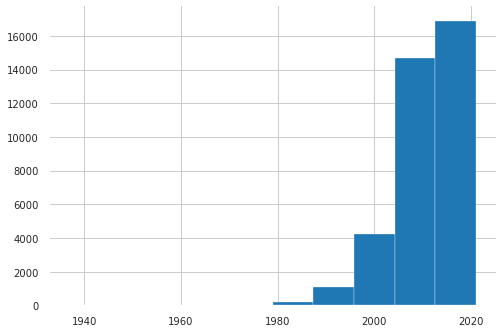

In [101]:
# тренировочная выборка
train.modelDate.hist()

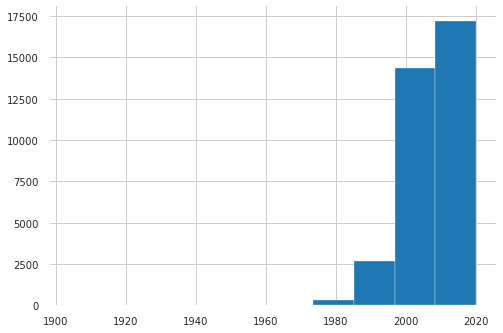

In [102]:
# тестовая выборка
test.modelDate.hist()

Как видно из графика, большинство авто, представленые в дата-сете, возрастом 20 и менее лет. Хотя есть и раритеты. Выделим на основе имеющихся данных новый признак, который отражает время, прошедшее с момента производства модели (Текущий год 2021):

In [103]:
train['model_time'] = datetime.now().year - train.modelDate

Проверим, что получилось:

In [104]:
train.model_time.unique()

array([ 8, 10,  4,  6,  7, 16, 11,  2,  3,  1,  5, 21, 13,  9, 12, 17, 49,
       15, 23, 14, 19, 26, 20, 29, 18, 65, 25, 30, 27, 22, 28, 31, 33, 24,
       39, 34,  0, 45, 37, 38, 48, 35, 42, 32, 40, 36, 75, 50, 51, 68, 44,
       53, 43, 63, 58, 66, 57, 47, 56, 41, 62, 52, 46, 60, 69, 61, 64, 72,
       84, 71, 83])

Повторим для тестовой выборки:

In [105]:
test['model_time'] = datetime.now().year - test.modelDate

Проверим результат:

In [106]:
test.model_time.unique()

array([  8,   4,  13,  12,   5,   9,   6,  11,  15,  21,  14,  27,  17,
        22,  16,  45,  20,  52,  25,  23,  32,  87,   7,  10,   3,  35,
        24,  31,   2,  19,  30,  34,  41,  39,  83,  33,  18,  38,  43,
        42,  37,  29,  26,  28,  36,  47,  55,  44,  40,  49,  53,  46,
        72,  84,  85,  48,  62,  63,   1,  56,  50, 117,  58,  66,  70,
        61])

Добавим новый признак к числовым:

In [107]:
num_cols.append('model_time')

### 3.2.12 Столбец model_name

Данный признак отражает название модели авто. Посмотрим на пропуски:

In [108]:
print(train.model_name.isna().sum())
print(test.model_name.isna().sum())

0
0


Пропусков нет, посмотрим на сами данные:

In [109]:
train.model_name.value_counts()

OCTAVIA                                      1135
CAMRY                                         802
5ER                                           767
POLO                                          713
E_KLASSE                                      656
                                             ... 
Infiniti QX50 I Рестайлинг                      1
2000_C_CS                                       1
Jeep Liberty (North America) I                  1
Chery Tiggo (T11) I Рестайлинг (FL)             1
BMW 7 серии  VI (G11/G12) Рестайлинг 730i       1
Name: model_name, Length: 2498, dtype: int64

Попробуем привести значения к нижнему регистру и удалить лишние пробелы:

In [110]:
train['model_name'] = train['model_name'].apply(
    lambda x: x.lower().strip())
train['model_name'].value_counts()

octavia                            1135
camry                               802
5er                                 767
polo                                713
e_klasse                            656
                                   ... 
nissan juke nismo i                   1
volkswagen golf plus  ii bifuel       1
уаз 469  469б                         1
ssangyong actyon  i 6-speed           1
citroen berlingo ii                   1
Name: model_name, Length: 2497, dtype: int64

Как мы видим,решение почти не помогло. Но, тем не менее, применим его и к тестовой выборке:

In [111]:
# Посчитаем количество упоминаний каждого значения в тестовой выборке
test.model_name.value_counts()

OCTAVIA         1418
5ER             1026
LANCER           855
E_KLASSE         809
PASSAT           782
                ... 
KIX                1
EMERAUDE           1
MEGA_CRUISER       1
I8                 1
M1                 1
Name: model_name, Length: 544, dtype: int64

In [112]:
test['model_name'] = test['model_name'].apply(
    lambda x: x.lower().strip())
test['model_name'].value_counts()

octavia     1418
5er         1026
lancer       855
e_klasse     809
passat       782
            ... 
vaneo          1
popular        1
rs4            1
arteon         1
m1             1
Name: model_name, Length: 544, dtype: int64

И здесь особого результата не дало. Запишем признак в категориальные:

In [113]:
cat_cols.append('model_name')

### 3.2.13. Столбец name

Признак содержит расширенные данные. Посмотрим данные:

In [114]:
train.name.value_counts()

2.0 AT                                 1239
1.6 AT                                  921
1.6 MT                                  846
3.0 AT                                  763
Volkswagen Polo  V Рестайлинг           374
                                       ... 
BMW 2 серии  F22 220d                     1
Mercedes-Benz S-Класс  I (W116) 350       1
Mercedes-Benz E-Класс  I (W124) 320       1
Nissan GT-R  I Рестайлинг 3               1
Toyota Avensis  III Рестайлинг            1
Name: name, Length: 2391, dtype: int64

In [115]:
test.name.value_counts()

1.6 AT (110 л.с.)         631
1.6 MT (102 л.с.)         410
1.6 MT (110 л.с.)         314
2.0 CVT (141 л.с.) 4WD    309
1.4 AMT (122 л.с.)        308
                         ... 
L1 2.2d MT (150 л.с.)       1
1.3 MT (99 л.с.)            1
T-5R 2.3 AT (240 л.с.)      1
3.0d MT (239 л.с.) 4WD      1
0.7 CVT (49 л.с.) 4WD       1
Name: name, Length: 2780, dtype: int64

Видно, что в данных содержится непонятная "каша" из других столбцов. Таким образом данный столбец только дублирует данные. Смысловой нагрузки не несет и для обучения использоваться не будет.

### 3.2.14. Столбец numberOfDoors

Признак содержит информацию о количестве дверей авто. Проверим на пропуски:

In [116]:
print(train.numberOfDoors.isna().sum())
print(test.numberOfDoors.isna().sum())

0
0


Посмотрим сами данные:

In [117]:
# Обучающая выборка
train.numberOfDoors.value_counts()

5    21794
4    13685
2     1155
3      603
Name: numberOfDoors, dtype: int64

In [118]:
# Тестовая выборка
test.numberOfDoors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

А вот в тестовой выборке возникло совершенно внезапно значение 0. Либо это бездверная капсула, либо опечатка. Я надеюсь опечатка. Заменим значение медианой:

In [119]:
test['numberOfDoors'] = test['numberOfDoors'].apply(
    lambda x: int(test['numberOfDoors'].median()) if x == 0 else int(x))

Проверим результат:

In [120]:
test.numberOfDoors.value_counts()

5    18704
4    14126
2     1206
3      650
Name: numberOfDoors, dtype: int64

Посмотрим графики распределения значений признака:

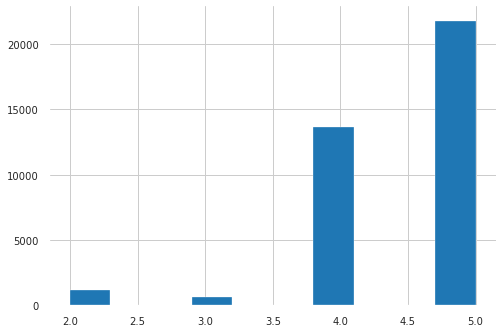

In [121]:
# Тренировочная выборка
train.numberOfDoors.hist()

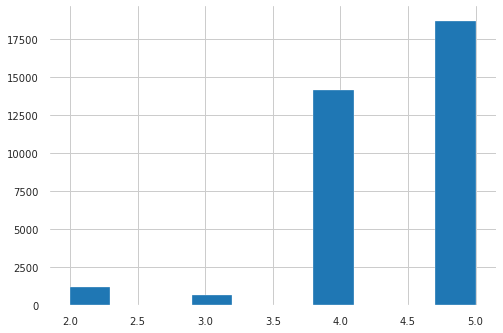

In [122]:
# Тестовая выборка
test.numberOfDoors.hist()

Видно, что распределения схожи. Наибольшее количество объявлений о продаже авто содержат пятидверные автомобили. Теперь добавим признак к категориальным:

In [123]:
cat_cols.append('numberOfDoors')

### 3.2.15. Столбец parsing_unixtime

Данный признак содержит информацию о времени, когда была спарсена информация об авто. Присутствует только в тестовой выборке. Поэтому использовать для обучения не будем.

### 3.2.16. Столбец priceCurrency

Признак содержит информацию о том, какая валюта используется при продаже. Посмотрим на данные:

In [124]:
print(train.priceCurrency.unique())
print(test.priceCurrency.unique())

['RUB']
['RUB']


Как мы видим признак принимает всего одно значение "RUB". Особой информативности признак не несет и в обучении роли не сыграет, поэтому пропустим его.

### 3.2.17. Столбец productionDate

Признак содержит информацию о годе производства авто. Проверим пропуски:

In [125]:
print(train.productionDate.isna().sum())
print(test.productionDate.isna().sum())

0
0


Пропусков нет, проверим сами данные:

In [126]:
train.productionDate.unique()

array([2016, 2014, 2018, 2015, 2017, 2008, 2011, 2019, 2020, 2004, 2012,
       2013, 2010, 1985, 2001, 2007, 1999, 2003, 1998, 2006, 1994, 2002,
       2009, 2021, 1960, 2005, 1995, 1996, 1997, 1993, 1959, 2000, 1992,
       1978, 1988, 1991, 1987, 1989, 1981, 1983, 1969, 1961, 1952, 1976,
       1979, 1971, 1963, 1980, 1986, 1964, 1982, 1953, 1990, 1958, 1984,
       1967, 1975, 1962, 1973, 1974, 1965, 1972, 1977, 1957, 1968, 1949,
       1937, 1950, 1938])

И для тестовой выборки:

In [127]:
test.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948])

На всякий случай проверим корреляцию между productionDate и modelDate

In [128]:
train[['modelDate', 'productionDate']].corr()

,modelDate,productionDate
modelDate,1.000000,0.972688
productionDate,0.972688,1.000000


In [129]:
test[['modelDate', 'productionDate']].corr()

,modelDate,productionDate
modelDate,1.000000,0.974293
productionDate,0.974293,1.000000


Корреляция очень высокая, значит один признак почти дублирует другой, а это может негативно сказаться на обучении. Во избежание этого, оставим только один из признаков, то есть modelDate, который мы добавили выше.

### 3.2.18. Столбец sell_id

Признак содержит уникальный идентификатор объявления о продаже. Особой информативности не несет, поэтому в дальнейшем использоваться не будет. В дополнение - присутствует только в тестовой выборке.

### 3.2.19. Столбец vehicleConfiguration

Признак содержит информацию о конфигурации транспортного средства. Посмотрим данные:

In [130]:
train.vehicleConfiguration.value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0     2774
ALLROAD_5_DOORS AUTOMATIC 2.0     1987
SEDAN AUTOMATIC 2.0               1927
ALLROAD_5_DOORS VARIATOR 2.0      1472
SEDAN MECHANICAL 1.6              1329
                                  ... 
PICKUP_ONE_HALF AUTOMATIC 5.0        1
MICROVAN VARIATOR 0.7                1
COUPE_HARDTOP AUTOMATIC 2.7          1
MINIVAN AUTOMATIC 3.4                1
ALLROAD_3_DOORS MECHANICAL 3.2       1
Name: vehicleConfiguration, Length: 702, dtype: int64

In [131]:
test.vehicleConfiguration.value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0     2389
SEDAN AUTOMATIC 2.0               1610
ALLROAD_5_DOORS AUTOMATIC 2.0     1327
ALLROAD_5_DOORS VARIATOR 2.0      1323
SEDAN MECHANICAL 1.6              1314
                                  ... 
COUPE MECHANICAL 3.2                 1
CABRIO AUTOMATIC 3.5                 1
PICKUP_ONE_HALF MECHANICAL 2.4       1
COMPACTVAN VARIATOR 2.4              1
PICKUP_ONE MECHANICAL 2.0            1
Name: vehicleConfiguration, Length: 634, dtype: int64

Как мы видим столбец дублирует данные из других признаков. В этом случае - информативности он не несет, поэтому при обучении использоваться не будет.

### 3.2.20. Столбец vehicleTransmission

Признак содержит информацию о типе коробки передач, используемой в транспортном средстве. Проверим на пропуски:

In [132]:
print(train.vehicleTransmission.isna().sum())
print(test.vehicleTransmission.isna().sum())

0
0


Пропусков не наблюдается, посмотрим уникальные значения для обеих выборок:

In [133]:
print(train.vehicleTransmission.unique())
print(test.vehicleTransmission.unique())

['вариатор' 'автоматическая' 'роботизированная' 'механическая']
['роботизированная' 'механическая' 'автоматическая' 'вариатор']


Признак принимает всего 4 значения, пропусков нет, может быть добавлен к категориальным признакам. Посмотрим на распределение признака:

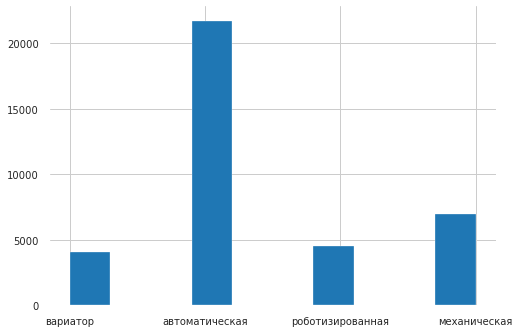

In [134]:
# Тренировочная выборка
train.vehicleTransmission.hist()

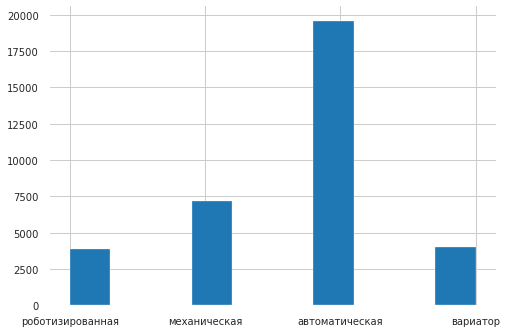

In [135]:
# Тестовая выборка
test.vehicleTransmission.hist()

Из графика видно, что чаще всего встречается автоматическая коробка передач. Добавляем признак к категориальным:

In [136]:
cat_cols.append('vehicleTransmission')

### 3.2.21. Столбец Владельцы

Признак содержит информацию о количестве владельцев авто. Посмотрим пропуски:

In [137]:
print(train.Владельцы.isna().sum())
print(test.Владельцы.isna().sum())

0
0


Пропусков нет, посмотрим на уникальные значения:

In [138]:
# Обучающая выборка
train.Владельцы.unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более', '1 владелец',
       '2 владельца'], dtype=object)

In [139]:
# Тестовая выборка
test.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

Как мы видим, данные загрязнены. Попробуем очистить их:

In [140]:
train['Владельцы'] = train['Владельцы'].apply(
    lambda x: str(x).replace('\xa0', ' '))

Проверим, что получилось:

In [141]:
train.Владельцы.unique()

array(['1 владелец', '2 владельца', '3 или более'], dtype=object)

Все работает как и должно. Применим к тестовой выборке аналогичный прием:

In [142]:
test['Владельцы'] = test['Владельцы'].apply(
    lambda x: str(x).replace('\xa0', ' '))

Убедимся, что все хорошо:

In [143]:
test.Владельцы.unique()

array(['3 или более', '1 владелец', '2 владельца'], dtype=object)

Посмотрим распределение признака для обеих выборок:

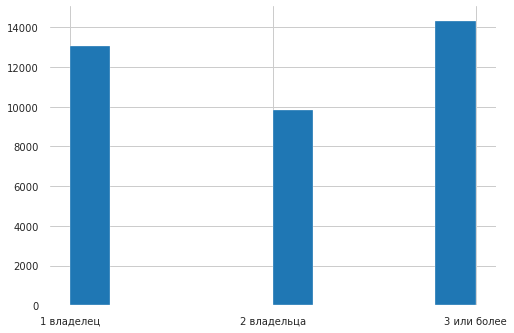

In [144]:
# Обучающая выборка
train.Владельцы.hist()

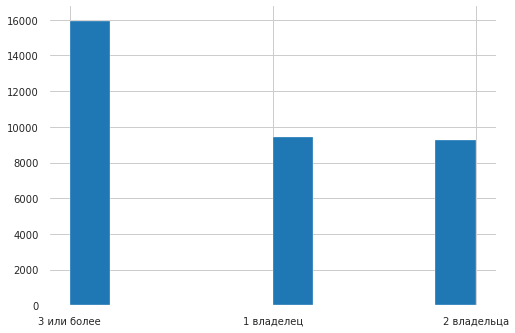

In [145]:
# Тестовая выборка
test.Владельцы.hist()

Как мы видим, преобладают авто, у которых было 3 и более владельцов, но в целом - различие с другими значениями не настолько сильное в случае тренировочной выборки. Добавим признак к категориальным:

In [146]:
cat_cols.append('Владельцы')

### 3.2.22. Столбец ПТС

Данный признак содержит информацию о ПТС автомобиля. Проверим на пропуски:

In [147]:
print(train.ПТС.isna().sum())
print(test.ПТС.isna().sum())

0
1


У нас есть один пропуск в тестовой выборке. Посмотрим на значения, принимаемые признаком, чтобы понять, что мы можем сделать:

In [148]:
train.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

Как мы видим, признак принимает два значения. Посмотрим тестовую выборку:

In [149]:
test.ПТС.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

Заменим пропуск значением моды для данного признака:

In [150]:
test['ПТС'] = test['ПТС'].apply(
    lambda x: test['ПТС'].mode()[0] if pd.isna(x) else x)

Просмотрим результат:

In [151]:
test.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

Посмотрим распределение признака:

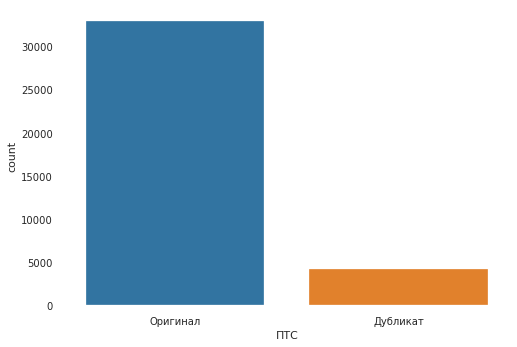

In [152]:
# Тренировочная выборка
sns.countplot(x='ПТС', data=train)

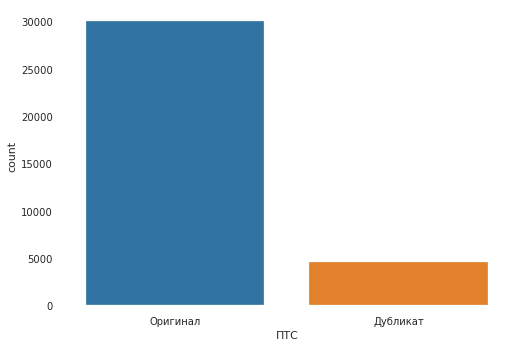

In [153]:
# Тестовая выборка
sns.countplot(x='ПТС', data=test)

Из распределения видно, что оригиналов ПТС гораздо больше чем дубликатов в обеих выборках. Данный признак является бинарным. Добавим его:

In [154]:
bin_cols.append('ПТС')

### 3.2.23. Столбец Привод

Признак содержит информацию о том, какой привод у транспортного средства. Проверим на пропуски:

In [155]:
print(train.Привод.isna().sum())
print(test.Привод.isna().sum())

0
0


Пропусков нет. Просмотрим сами данные:

In [156]:
train.Привод.unique()

array(['полный', 'задний', 'передний'], dtype=object)

Повторим для тестовой выборки:

In [157]:
test.Привод.unique()

array(['передний', 'полный', 'задний'], dtype=object)

Признак категориальный, посмотрим распределение значений:

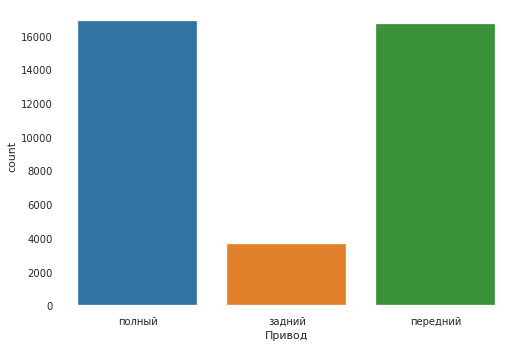

In [158]:
# Тренировочная выборка
sns.countplot(x='Привод', data=train)

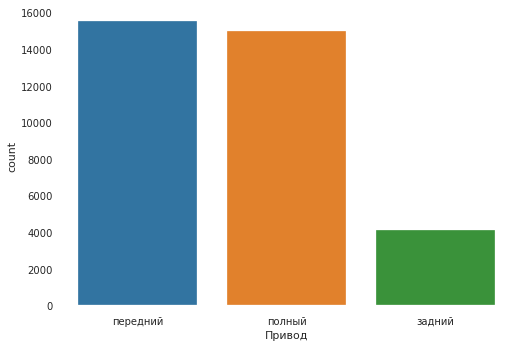

In [159]:
# Тестовая выборка
sns.countplot(x='Привод', data=test)

Распределение признаков для обеих выборок похож. Наибольший процент в дата-сетах составляют передний и полный привод. Дальнейшей обработки не требуется, добавим признак к остальным категориальным:

In [160]:
cat_cols.append('Привод')

### 3.2.24. Столбец Руль

Признак отражает положение руля в автомобиле. Просмотрим данные:

In [161]:
# Тренировочная выборка
train.Руль.unique()

array(['Левый', 'Правый'], dtype=object)

In [162]:
# Тестовая выборка
test.Руль.unique()

array(['Левый', 'Правый'], dtype=object)

Пропусков нет, признак является бинарным. Посмотрим его распределение для обеих выборок:

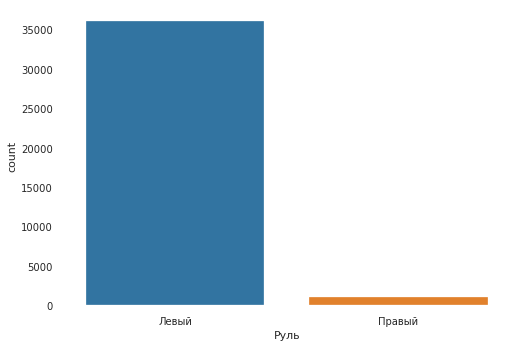

In [163]:
# Тренировочная выборка
sns.countplot(x='Руль', data=train)

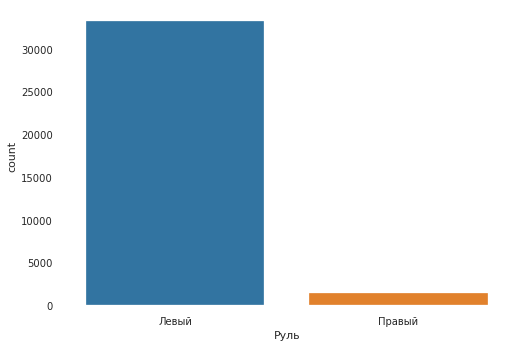

In [164]:
# Тестовая выборка
sns.countplot(x='Руль', data=test)

Из графика видно, что преобладают автомобили с левым рулем. Дальнейшей обработки признак не требует, добавим к бинарным:

In [165]:
bin_cols.append('Руль')

### 3.2.25. Столбец Состояние

Признак описывает состояние авто. Просмотрим данные:

In [166]:
# Тренировочная выборка
train.Состояние.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [167]:
# Тестовая выборка
test.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

В тестовой выборке только одно значение признака, однако в тренировочной два. Посмотрим распределение для тренировочной выборки:

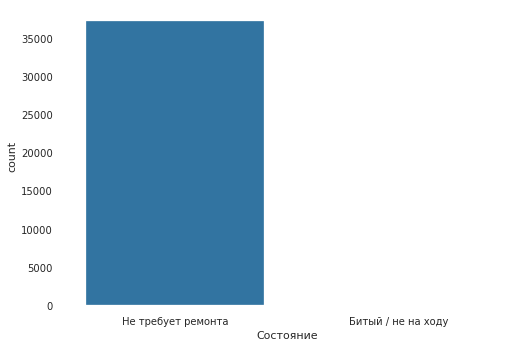

In [168]:
# Тренировочная выборка
sns.countplot(x='Состояние', data=train)

Посчитаем значения:

In [169]:
train.Состояние.value_counts()

Не требует ремонта    37235
Битый / не на ходу        2
Name: Состояние, dtype: int64

Как видно и из распределения и проверки количества значений, признак все же является бинарным, хотя второе значение присутствует в ничтожно малом количестве. Добавим к бинарным:

In [170]:
bin_cols.append('Состояние')

### 3.2.26. Столбец Таможня

Признак отражает, что автомобиль растоможен, и одинаков для всех строк. Смысловой нагрузки не несет и смысла добавлять его в обучение нет, пропускаем.

### 3.2.27. Целевой столбец price

Искомый признак, отражающий стоимость автомобиля. Присутствует только в тренировочной выборке. Просмотрим уникальные значения и пропуски:

In [171]:
train.price.isna().sum()

0

Пропусков нет.

In [172]:
train.price.unique()

array(['1\xa0319\xa0000\xa0₽', '1\xa0470\xa0000\xa0₽',
       '4\xa0447\xa0000\xa0₽', ..., 799999, 336499, 78000], dtype=object)

Данные грязные, требуют предварительной очистки. Приступим:

In [173]:
train['price'] = train['price'].apply(lambda x: str(x).replace('\xa0', ''))

проверим результат:

In [174]:
train.price.unique()

array(['1319000₽', '1470000₽', '4447000₽', ..., '168000', '474799',
       '336499'], dtype=object)

Пол дела сделано, теперь нужно убрать обозначение валюты:

In [175]:
train['price'] = train['price'].apply(lambda x: str(x).replace('₽', ''))

Еще раз проверим:

In [176]:
train.price.unique()

array(['1319000', '1470000', '4447000', ..., '168000', '474799', '336499'],
      dtype=object)

Весь мусор удален, теперь приведем столбец к числовому формату:

In [177]:
train['price'] = train['price'].apply(lambda x: int(x))

И снова проверим:

In [178]:
train.price.unique()

array([1319000, 1470000, 4447000, ...,  168000,  474799,  336499])

Все нормально преобразовалось. Посмотрим распределение целевого признака:

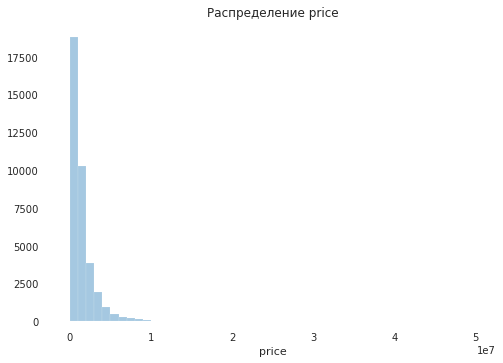

In [179]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(train.price, kde=False)

Как мы видим, большинство цен лежит в диапазоне от 0 до 1 млн. рублей. Помимо этого присутствуют выбросы, но они не противоречат здравому смыслу. Теперь рассмотрим влияние некоторых признаков на цену:

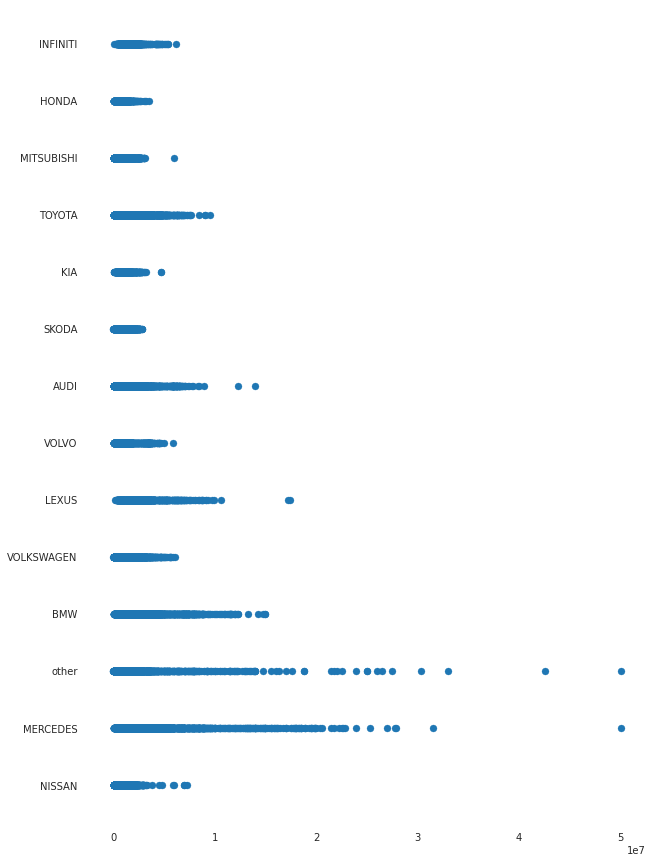

In [180]:
plt.figure(figsize=(10, 15))
plt.scatter((train.price), train.brand_new)

Что логично, чем "элитнее" авто, тем больше у него становится разброс цен. Также некоторый вклад вносят и авто, которые мы отнесли к типу other. Возможно там имеются раритеты, которые могут много стоить.

Теперь посмотрим зависимость цены от привода:

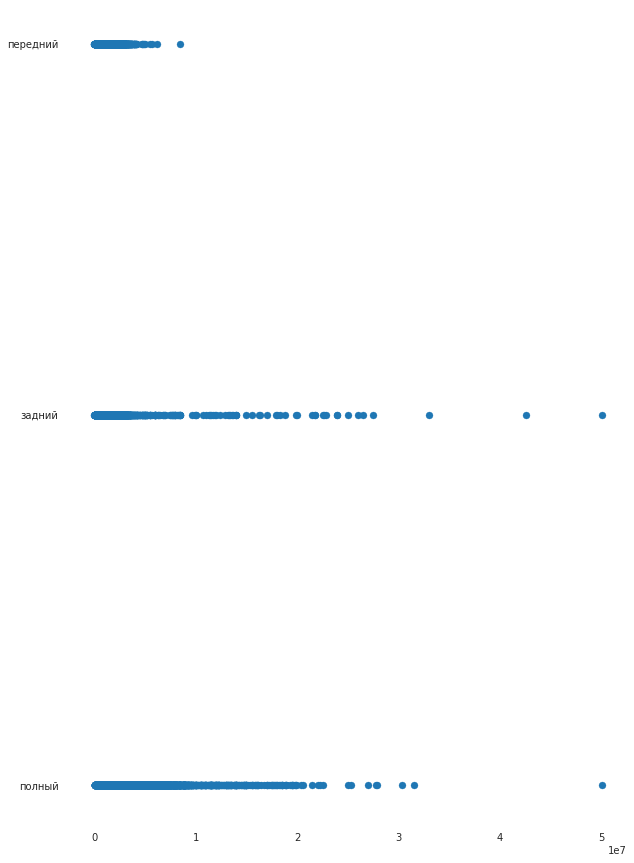

In [181]:
plt.figure(figsize=(10, 15))
plt.scatter((train.price), train.Привод)

Наименьший разброс цен наблюдается у переднего привода, а наименее сгруппированным является полный привод. Вероятно это связано с разнообразием различных автомобилей из разных классов, имеющих данную характеристику.

Проверим аналогичным способом, как влияет количество владельцев на стоимость автомобиля:

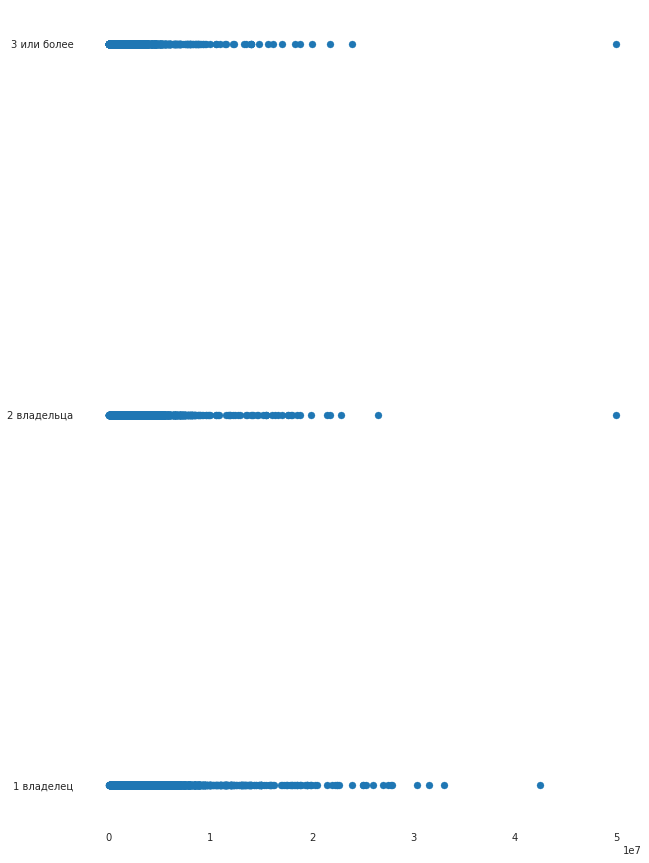

In [182]:
plt.figure(figsize=(10, 15))
plt.scatter((train.price), train.Владельцы)

Из графика видно, что с увеличением числа владельцев увеличивается сгруппированность у "меньшей" стоимости автомобиля.

## 3.3. Label Encoding

Для дальнейшей обработки соединим оба фрейма в один:

In [183]:
train['sample_'] = 0
test['sample_'] = 1
df = pd.concat([test, train])
df = df.reset_index().drop(['index'], axis=1)

Теперь оставим только выделенные признаки из нашего дата-сета, которые будут нужны для обучения:

In [184]:
df = df[cat_cols + bin_cols + num_cols + ['price', 'sample_']]

Проверим результаты:

In [185]:
df.head(1)

,bodyType,brand_new,color,fuelType,model_name,numberOfDoors,vehicleTransmission,Владельцы,Привод,ПТС,Руль,Состояние,comment_length,engineDisplacement,enginePower,mileage,model_time,price,sample_
0,лифтбек,NISSAN,синий,бензин,octavia,5,роботизированная,3 или более,передний,Оригинал,Левый,Не требует ремонта,1001,1.2,105,74000,8,NaN,1


Теперь приступим непосредственно к самой обработке столбцов

### 3.3.1. Обработка бинарных признаков

Для начала необходимо преобразовать полученные признаки при помощи Label Encoding'а:

In [186]:
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

Проверим правильность выполнения:

In [187]:
df[bin_cols].head(5)

,ПТС,Руль,Состояние
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1


Визуально, преобразовалось все хорошо, но проверим дополнительно при помощи value_counts():

In [188]:
for col in bin_cols:
    display(df[col].value_counts())

1    63084
0     8839
Name: ПТС, dtype: int64

0    69423
1     2500
Name: Руль, dtype: int64

1    71921
0        2
Name: Состояние, dtype: int64

Посмотрим значимость признаков:

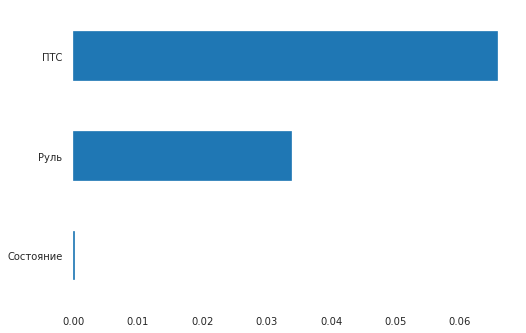

In [189]:
imp_cat = Series(mutual_info_classif(df[df.sample_ == 0][bin_cols], df[df.sample_ == 0]['price'],
                                     discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наибольшее влияние на цену оказывает признак ПТС, Состояние же вклада почти не делает. Данная логика является странной, ведь большее влияние должно оказывать как раз Состояние транспортного средства. Скорее всего это связано с тем, что у нас фактически отсутствует второе значение данного признака.

### 3.3.2. Категориальные признаки

На всякий случай еще раз посмотрим количество уникальных значений для каждого признака из списка:

In [190]:
for col in cat_cols:
    print(f'{col}', df[col].nunique())

bodyType 18
brand_new 14
color 16
fuelType 5
model_name 2550
numberOfDoors 4
vehicleTransmission 4
Владельцы 3
Привод 3


Видно что уникальных значений для некоторых переменных довольно много:

Теперь перекодируем признаки при помощи cat.codes на основе имеющихся категориальных столбцов:

In [192]:
for column in cat_cols:
    df[column] = df[column].astype('category').cat.codes

проверим результат:

In [194]:
df.head(5)

,bodyType,brand_new,color,fuelType,model_name,numberOfDoors,vehicleTransmission,Владельцы,Привод,ПТС,Руль,Состояние,comment_length,engineDisplacement,enginePower,mileage,model_time,price,sample_
0,6,8,13,0,1749,3,3,2,1,1,0,1,1001,1.2,105,74000,8,NaN,1
1,6,6,15,0,1749,3,2,0,1,1,0,1,2609,1.6,110,60563,4,NaN,1
2,6,13,12,0,2154,3,3,0,1,1,0,1,1001,1.8,152,88000,8,NaN,1
3,6,1,6,0,1749,3,0,0,1,1,0,1,1676,1.6,110,95000,8,NaN,1
4,6,1,1,0,1749,3,0,0,1,1,0,1,2365,1.8,152,58536,13,NaN,1


Все преобразовалось правильно.

Посмотрим значимость категориальных признаков:

In [ ]:
imp_num = Series(f_classif(df[cat_cols][df['sample_'] == 0], df[df['sample_'] == 0]['price'])[0],
                 index=cat_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Как мы можем заметить, наибольший вклад осуществляют признаки "bodyType,Владельцы,fuelType". В целом, вклад почти всех признаков является большим.

### 3.3.3. Числовые признаки

Посмотрим на сами числовые признаки и их корреляцию:

In [195]:
df[df['sample_'] == 0][num_cols + ['price']]

,comment_length,engineDisplacement,enginePower,mileage,model_time,price
34686,1276,2.0,144,69850,8,1319000.0
34687,411,1.6,156,119075,10,1470000.0
34688,393,2.0,300,25800,4,4447000.0
34689,180,2.0,150,56000,6,2069990.0
34690,2212,3.0,218,80800,8,2760000.0
...,...,...,...,...,...,...
71918,162,1.5,115,373317,22,210000.0
71919,989,1.7,130,311000,19,330000.0
71920,398,1.8,140,196000,13,430000.0
71921,208,1.4,90,350000,21,135000.0


Теперь построим корреляцию:

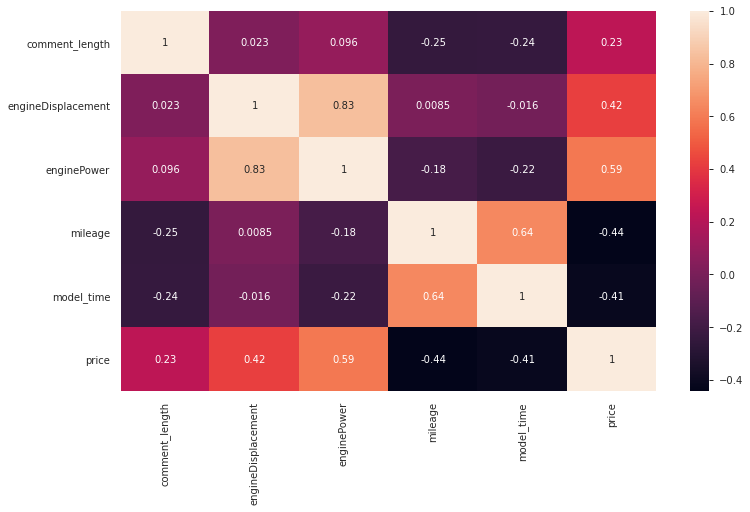

In [196]:
plt.figure(figsize=(12, 7))
sns.heatmap(df[df['sample_'] == 0][num_cols + ['price']].corr(), annot=True)

Мы видим, что наибольшая зависимость между признаками enginePower и engineDisplacement. Так как мощность двигателя является более показательным признаком, оставим его, а признак engineDisplacement удалим из выборки и из num_cols.

In [197]:
num_cols.remove('engineDisplacement')
df = df.drop(['engineDisplacement'], axis=1)

Все остальные признаки находятся в пределах относительной нормы, очень высокой корреляции не наблюдается. Посмотрим на значимость числовых признаков:

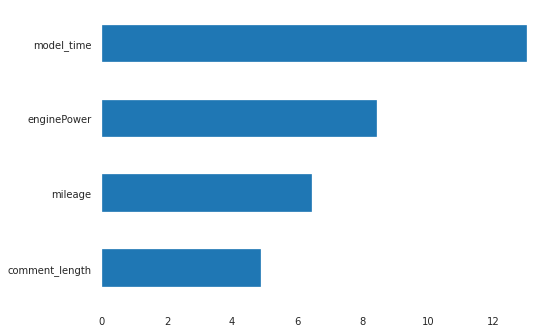

In [198]:
imp_num = Series(f_classif(df[num_cols][df['sample_'] == 0], df[df['sample_'] == 0]['price'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Влияние всех признаков высокое. Наиболее важными признаками являются model_time и enginePower

Теперь, когда преобразование всех признаков закончено, можно перейти к созданию и обучению моделей.

# 4. Обучение

## 4.1. Train Split

Разделим наш дата-фрейм обратно на тренировочный и тестовый:

In [199]:
df_train = df[df.sample_ == 0]
df_test = df[df.sample_ == 1].drop(['price', 'sample_'], axis=1).values

Теперь разделим наш тренировочный дата-сет на обучающую и валидационную выборки:

In [200]:
X = df_train.drop(['price', 'sample_'], axis=1)
Y = df_train['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=VAL_SIZE, random_state=RANDOM_SEED)

## 4.2. Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по мощности двигателя (enginePower). 
C ней будем сравнивать другие модели.




In [201]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [202]:
# Находим median по экземплярам enginepower в трейне и размечаем тест
predict = X_test['enginePower'].map(
    tmp_train.groupby('enginePower')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 62.68%


Получили ужасную метрику. Посмотрим, что получится дальше.

## 4.3. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

### 4.3.1 Fit

Разделим еще раз на обучающую и валидационную выборки:

In [203]:
X = df_train.drop(['price', 'sample_'], axis=1).values
Y = df_train['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=VAL_SIZE, random_state=RANDOM_SEED)

In [204]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          )

model.save_model('catboost_single_model_baseline.model')

In [205]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.98%


Уже лучше, чем у наивной модели. Попробуем логарифмировать.

### 4.3.2. Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    


In [206]:
np.log(y_train)

array([14.38818359, 13.86905132, 15.17391972, ..., 13.73212895,
       13.9552725 , 14.96798773])

In [207]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train+1),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          )

model.save_model('catboost_single_model_2_baseline.model')

In [208]:
predict_test = np.exp(model.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.01%


Точность выросла еще, однако недостаточно. Исследуем другие модели.

## 4.4. Другие модели

### 4.4.1. Линейная регрессия

Начнем с самого простого, линейной регрессии:

In [209]:
linreg = LinearRegression().fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(linreg.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(linreg.predict(X_test))

Точность модели по метрике MAPE: 28.46%


Точность все еще плохая, возможно дальше будет лучше.

### 4.4.2. Градиентный бустинг

In [210]:
grb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=RANDOM_SEED)
grb.fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(grb.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(grb.predict(X_test))

Точность модели по метрике MAPE: 14.48%


Получили значение, немного большее, чем при catBoost

### 4.4.3. RandomForest

Опробуем RandomForest с подбором параметров:

In [211]:
"""
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_random.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(rf_random.predict(X_test))
#Точность модели по метрике MAPE: 15.88%
"""

'\nrandom_grid = {\'n_estimators\': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],\n               \'max_features\': [\'auto\', \'sqrt\'],\n               \'max_depth\': [int(x) for x in np.linspace(10, 110, num = 11)],\n               \'min_samples_split\': [2, 5, 10],\n               \'min_samples_leaf\': [1, 2, 4],\n               \'bootstrap\': [True, False]}\n\nrf = RandomForestRegressor(random_state=RANDOM_SEED)\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, \n                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)\nrf_random.fit(X_train, np.log(y_train+1))\nprint(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_random.predict(X_test))))*100:0.2f}%")\npredict_test = np.exp(rf_random.predict(X_test))\n#Точность модели по метрике MAPE: 15.88%\n'

Получили результат метрики 15.88%. Выполняется ужасно долго, около четырех часов. Пока лучший результат показал градиентный бустинг. Попробуем собрать ансамбль.

### 4.4.4. Ансамбль алгоритмов

In [212]:
estimators = [('cb', CatBoostRegressor(iterations=5000,
                                       random_seed=RANDOM_SEED,
                                       eval_metric='MAPE',
                                       custom_metric=['R2', 'MAE'],
                                       silent=True)),
              ('rf', RandomForestRegressor(n_estimators=500,
                                           n_jobs=-1,
                                           max_depth=15,
                                           max_features='log2',
                                           random_state=RANDOM_SEED,
                                           oob_score=True)),
              ('lr', LinearRegression(normalize=True,
                                      n_jobs=-1))]


st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                    min_samples_split=2,
                                    learning_rate=0.03,
                                    max_depth=10,
                                    n_estimators=500))


st_ensemble.fit(X_train, np.log(y_train+1))


print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(st_ensemble.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(st_ensemble.predict(X_test))

Точность модели по метрике MAPE: 14.90%


Получили метрику 14,9%. Возможно не очень хорошая метрика связана с выбором параметров либо их качеством обработки. Я не могу дать точного ответа на этот вопрос, как бы ни хотел. Можно было бы провести еще множество исследований, но не остается времени. Последнее, что попробуем - использовать StandardScaler на данных.

### 4.4.5. Ансамбль с standardScaler

In [213]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train
y_test = y_test

Теперь посмотрим, как поведет себя Ансамбль:

In [214]:
estimators = [('cb', CatBoostRegressor(iterations=5000,
                                       random_seed=RANDOM_SEED,
                                       eval_metric='MAPE',
                                       custom_metric=['R2', 'MAE'],
                                       silent=True)),
              ('rf', RandomForestRegressor(n_estimators=500,
                                           n_jobs=-1,
                                           max_depth=15,
                                           max_features='log2',
                                           random_state=RANDOM_SEED,
                                           oob_score=True)),
              ('lr', LinearRegression(normalize=True,
                                      n_jobs=-1))]


st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                    min_samples_split=2,
                                    learning_rate=0.03,
                                    max_depth=10,
                                    n_estimators=500))


st_ensemble.fit(X_train, np.log(y_train+1))


print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(st_ensemble.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(st_ensemble.predict(X_test))

Точность модели по метрике MAPE: 14.95%


Как мы видим, почти ничего не поменялось. Лучшие показатели дал только алгоритм Градиентного Бустинга, но разница не является очень сильной. Я склоняюсь к тому что стоит использовать последний алгоритм для решения задачи, поэтому выберем его в качестве решения и приступим к сабмиту

# Submission

Обучим алгоритм на всей выборке:

In [215]:
st_ensemble.fit(X, np.log(Y+1))

StackingRegressor(estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x7f2cd936d9d0>),
                              ('rf',
                               RandomForestRegressor(max_depth=15,
                                                     max_features='log2',
                                                     n_estimators=500,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=76)),
                              ('lr',
                               LinearRegression(n_jobs=-1, normalize=True))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.03,
                                                            max_depth=10,
                                                            n_estimators=500))

Теперь применим к тестовой выборке:

In [216]:
# округляем, чтобы были целые числа
predict_submission = np.round(
    np.exp(st_ensemble.predict(df_test)), -3).astype('int')

Готовим и сохраняем сабмит:

In [217]:
VERSION = 3

In [218]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,625000
1,1100549428,1105000
2,1100658222,920000
3,1100937408,889000
4,1101037972,785000
5,1100912634,626000
6,1101228730,847000
7,1100165896,392000
8,1100768262,1635000
9,1101218501,659000


В итоге получили **MAPE 22%**!

Вероятно, признаки, которые мы подобрали не дают достоверного качества при обучении. Либо данных оказалось слишком мало, чтобы нормально обучить. Вариантов может быть очень много, но результат заключается в том, что нам удалось немного улучшить метрику ( Я честно постарался бы сделать это еще лучше, но не осталось времени.). В дальнейшем - стоит попробовать использовать иные преобразования категориальных признаков, возможно выделить большее их количество. А так, как результат мы получили разницу в метрике на тренировочной выборке и тестовой в ~7%. Как напутствие самому себе хочу отметить, что стоит выделять большее количество различных признаков. Возможно они смогли бы сыграть важную роль.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking